In [10]:
import pandas as pd
import numpy as np
import feather

from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as sp

In [817]:
def evaluation_metric(y_true, y_pred):
    y_pred = y_pred.copy()
    y_pred[y_pred < 1.0] = 1.0
    y_pred = np.round(y_pred)
    scores = (y_pred - y_true) / (y_pred + y_true)
    scores[y_true < 1] = 0.0
    return np.abs(scores).mean()

In [3]:
df_pays = feather.read_dataframe('data/df_pays_na.feather')

In [4]:
last_day = df_pays.day.max()
dt = (df_pays.day - last_day).apply(lambda d: (d.days - 1) // 7)

df_pays['week_id'] = -dt
df_pays['biweek_id'] = (df_pays.week_id + 1) // 2

df_pays['dow'] = df_pays.day.dt.dayofweek
df_pays['is_weekend'] = df_pays.dow.isin([5, 6])

In [589]:
df_pays['out_of_operation'] = df_pays.pays_count.isnull().astype('float')

In [628]:
def shift_index(series):
    s = series.copy()
    s.index = s.index - 1
    return s

In [629]:
def add_out_of_operation_features(df_shop):
    ooo_sum_1 = shift_index(ooo_sum)
    ooo_sum_2 = shift_index(ooo_sum_1)
    ooo_sum_3 = shift_index(ooo_sum_2)
    ooo_sum_4 = shift_index(ooo_sum_3)

    ooo_cnt_1 = shift_index(ooo_cnt)
    ooo_cnt_2 = shift_index(ooo_cnt_1)
    ooo_cnt_3 = shift_index(ooo_cnt_2)
    ooo_cnt_4 = shift_index(ooo_cnt_3)

    ooo_mean_1 = ooo_sum_1 / ooo_cnt_1
    ooo_mean_2 = (ooo_sum_1 + ooo_sum_2) / \
                 (ooo_cnt_1 + ooo_cnt_2)
    ooo_mean_3 = (ooo_sum_1 + ooo_sum_2 + ooo_sum_3) / \
                 (ooo_cnt_1 + ooo_cnt_2 + ooo_cnt_3)
    ooo_mean_4 = (ooo_sum_1 + ooo_sum_2 + ooo_sum_3 + ooo_sum_4) / \
                 (ooo_cnt_1 + ooo_cnt_2 + ooo_cnt_3 + ooo_cnt_4)

    df_shop['ooo_mean_1'] = ooo_mean_1[df_shop.biweek_id].reset_index(drop=1)
    df_shop['ooo_mean_2'] = ooo_mean_2[df_shop.biweek_id].reset_index(drop=1)
    df_shop['ooo_mean_3'] = ooo_mean_3[df_shop.biweek_id].reset_index(drop=1)
    df_shop['ooo_mean_4'] = ooo_mean_4[df_shop.biweek_id].reset_index(drop=1)

In [656]:
df_shop = df_pays[df_pays.shop_id == 1].reset_index(drop=1)

    def add_rolling_features(df_shop):
        shift = df_shop.pays_count.shift(14)
        df_shop['count_two_weeks_ago'] = shift

        for w in [1, 2, 4, 8]:
            rolling = shift.rolling(7 * w)
            df_shop['rolling_mean_%d' % w] = rolling.mean()
            df_shop['rolling_min_%d' % w] = rolling.min()
            df_shop['rolling_max_%d' % w] = rolling.max()
            df_shop['rolling_std_%d' % w] = rolling.std()

            for i in range(0, 7):
                idx = df_shop.dow == i
                rolling = shift[idx].rolling(w)
                df_shop.loc[idx, 'rolling_mean_%d_dow' % w] = rolling.mean()
                df_shop.loc[idx, 'rolling_min_%d_dow' % w] = rolling.min()
                df_shop.loc[idx, 'rolling_max_%d_dow' % w] = rolling.max()
                df_shop.loc[idx, 'rolling_std_%d_dow' % w] = rolling.std()

        return df_shopy

In [285]:
def add_weekly_trends(df_train, df_val, regressor, result_name):
    y = df_train.pays_count
    not_null = ~y.isnull()

    x = -df_train[regressor]
    x_not_null = x[not_null].values.reshape(-1, 1)
    y = y[not_null].values
    lr = LinearRegression().fit(x_not_null, y)

    x = x.values.reshape(-1, 1)
    df_train[result_name] = lr.predict(x)

    x_val = -df_val[regressor].values.reshape(-1, 1)
    df_val[result_name] = lr.predict(x_val)

    return lr.coef_[0]

In [286]:
def add_weekly_trends_features(df_train, df_val):
    weekly_coef = add_weekly_trends(df_train, df_val, 'week_id', 'weekly_trend')
    biweekly_coef = add_weekly_trends(df_train, df_val, 'biweek_id', 'biweekly_trend')

    df_train['weekly_coef'] = weekly_coef
    df_val['weekly_coef'] = weekly_coef

    df_train['biweekly_coef'] = biweekly_coef
    df_val['biweekly_coef'] = biweekly_coef

    df_train['penultimate_biweekly_trend'] = df_train.penultimate + biweekly_coef
    df_val['penultimate_biweekly_trend'] = df_val.penultimate + biweekly_coef

    df_train['penultimate_weekly_trend'] = df_train.penultimate + weekly_coef
    first_week = df_train.loc[df_train.second_in_biweek == 1, 'penultimate_weekly_trend'] 
    df_train.loc[df_train.second_in_biweek == 1, 'penultimate_weekly_trend'] = first_week + weekly_coef

    df_val['penultimate_weekly_trend'] = df_val.penultimate + weekly_coef
    first_week = df_val.loc[df_val.second_in_biweek == 1, 'penultimate_weekly_trend'] 
    df_val.loc[df_val.second_in_biweek == 1, 'penultimate_weekly_trend'] = first_week + weekly_coef

In [287]:
def add_overall_trend_feature(df_train, df_val):
    y = df_train.pays_count
    not_null = ~y.isnull()

    x = df_train.days_from_beginning
    x_not_null = x[not_null].values.reshape(-1, 1)
    y = y[not_null].values
    lr = LinearRegression().fit(x_not_null, y)

    x = x.values.reshape(-1, 1)
    df_train['store_overall_trend'] = lr.predict(x)

    x_val = df_val.days_from_beginning.values.reshape(-1, 1)
    df_val['store_overall_trend'] = lr.predict(x_val)


def add_dow_trend_feature(df_train, df_val):
    df_train['store_dow_trend'] = np.nan
    df_val['store_dow_trend'] = np.nan

    for i in range(7):
        idx = (df_train.dow == i)

        y = df_train[idx].pays_count
        not_null = ~y.isnull()

        x = df_train[idx].days_from_beginning
        x_not_null = x[not_null].values.reshape(-1, 1)
        y = y[not_null].values
        lr = LinearRegression().fit(x_not_null, y)

        x = x.values.reshape(-1, 1)
        df_train.loc[idx, 'store_dow_trend'] = lr.predict(x)

        val_idx = (df_val.dow == i)
        x_val = df_val[val_idx].days_from_beginning.values.reshape(-1, 1)
        df_val.loc[val_idx, 'store_dow_trend'] = lr.predict(x_val)


def add_weekend_trend_feature(df_train, df_val):
    df_train['store_weekend_trend'] = np.nan
    df_val['store_weekend_trend'] = np.nan

    for i in [True, False]:
        idx = (df_train.is_weekend == i)

        y = df_train[idx].pays_count
        not_null = ~y.isnull()

        x = df_train[idx].days_from_beginning
        x_not_null = x[not_null].values.reshape(-1, 1)
        y = y[not_null].values
        lr = LinearRegression().fit(x_not_null, y)

        x = x.values.reshape(-1, 1)
        df_train.loc[idx, 'store_weekend_trend'] = lr.predict(x)

        val_idx = (df_val.is_weekend == i)
        x_val = df_val[val_idx].days_from_beginning.values.reshape(-1, 1)
        df_val.loc[val_idx, 'store_weekend_trend'] = lr.predict(x_val)    


def add_trend_features(df_train, df_val):
    add_overall_trend_feature(df_train, df_val)
    add_dow_trend_feature(df_train, df_val)
    add_weekend_trend_feature(df_train, df_val)

In [288]:
shops = df_pays.shop_id.unique()
shops = sorted(shops)

In [742]:
def add_window_trend_features(df_shop):
    biweek_max = df_shop.biweek_id.max()

    for biweeks_past in [2, 3, 4, 5, 6, 12, 18]:
        trend_name = 'trend_%d' % biweeks_past
        trend_coef_name = 'trend_coef_%d' % biweeks_past
        df_shop[trend_name] = np.nan
        df_shop[trend_coef_name] = np.nan

        for m in range(biweek_max, biweeks_past + 1, -1):
            m_past = m - biweeks_past
            train_idx = (df_shop.biweek_id >= m_past) & (df_shop.biweek_id <= m)
            test_idx = df_shop.biweek_id == (m_past - 1)

            df_rolling_train = df_shop[train_idx]
            df_rolling_test = df_shop[test_idx]

            y = df_rolling_train.pays_count
            not_null = ~y.isnull()
            if not_null.sum() <= 7:
                continue
        
            x = df_rolling_train.days_from_beginning
            x_not_null = x[not_null].values.reshape(-1, 1)
            y = y[not_null].values
            lr = Ridge(alpha=1).fit(x_not_null, y)

            if m == biweek_max:
                x = x.values.reshape(-1, 1)
                df_shop.loc[train_idx, trend_name] = lr.predict(x)
                df_shop.loc[train_idx, trend_coef_name] = lr.coef_[0]

            x_val = df_rolling_test.days_from_beginning.values.reshape(-1, 1)
            df_shop.loc[test_idx, trend_name] = lr.predict(x_val)
            df_shop.loc[test_idx, trend_coef_name] = lr.coef_[0]


def add_window_trend_dow_features(df_shop):
    biweek_max = df_shop.biweek_id.max()

    for biweeks_past in [3, 4, 5, 6, 12, 18]:
        trend_name = 'trend_dow_%d' % biweeks_past
        trend_coef_name = 'trend_dow_coef_%d' % biweeks_past
        df_shop[trend_name] = np.nan
        df_shop[trend_coef_name] = np.nan

        for m in range(biweek_max, biweeks_past + 1, -1):
            m_past = m - biweeks_past
            train_idx = (df_shop.biweek_id >= m_past) & (df_shop.biweek_id <= m)
            test_idx = df_shop.biweek_id == (m_past - 1)

            df_rolling_train = df_shop[train_idx]
            df_rolling_test = df_shop[test_idx]
            
            for i in range(7):
                dow_idx = (df_rolling_train.dow == i)
                dow_idx_test = (df_rolling_test.dow == i)

                y = df_rolling_train[dow_idx].pays_count
                not_null = ~y.isnull()
                if not_null.sum() <= 4:
                    continue

                x = df_rolling_train[dow_idx].days_from_beginning
                x_not_null = x[not_null].values.reshape(-1, 1)
                y = y[not_null].values
                lr = Ridge(alpha=1).fit(x_not_null, y)

                if m == biweek_max:
                    x = x.values.reshape(-1, 1)
                    df_shop.loc[train_idx & dow_idx, trend_name] = lr.predict(x)
                    df_shop.loc[train_idx & dow_idx, trend_coef_name] = lr.coef_[0]

                x_val = df_rolling_test[dow_idx_test].days_from_beginning.values.reshape(-1, 1)
                df_shop.loc[test_idx & dow_idx_test, trend_name] = lr.predict(x_val)
                df_shop.loc[test_idx & dow_idx_test, trend_coef_name] = lr.coef_[0]


def add_window_trend_weekend_features(df_shop):
    biweek_max = df_shop.biweek_id.max()

    for biweeks_past in [3, 4, 5, 6, 12, 18]:
        trend_name = 'trend_weekend_%d' % biweeks_past
        trend_coef_name = 'trend_weekend_coef_%d' % biweeks_past
        df_shop[trend_name] = np.nan
        df_shop[trend_coef_name] = np.nan

        for m in range(biweek_max, biweeks_past + 1, -1):
            m_past = m - biweeks_past
            train_idx = (df_shop.biweek_id >= m_past) & (df_shop.biweek_id <= m)
            test_idx = df_shop.biweek_id == (m_past - 1)

            df_rolling_train = df_shop[train_idx]
            df_rolling_test = df_shop[test_idx]
            
            for i in [True, False]:
                dow_idx = (df_rolling_train.is_weekend == i)
                dow_idx_test = (df_rolling_test.is_weekend == i)

                y = df_rolling_train[dow_idx].pays_count
                not_null = ~y.isnull()
                if not_null.sum() <= 4:
                    continue

                x = df_rolling_train[dow_idx].days_from_beginning
                x_not_null = x[not_null].values.reshape(-1, 1)
                y = y[not_null].values
                lr = Ridge(alpha=1).fit(x_not_null, y)

                if m == biweek_max:
                    x = x.values.reshape(-1, 1)
                    df_shop.loc[train_idx & dow_idx, trend_name] = lr.predict(x)
                    df_shop.loc[train_idx & dow_idx, trend_coef_name] = lr.coef_[0]

                x_val = df_rolling_test[dow_idx_test].days_from_beginning.values.reshape(-1, 1)
                df_shop.loc[test_idx & dow_idx_test, trend_name] = lr.predict(x_val)
                df_shop.loc[test_idx & dow_idx_test, trend_coef_name] = lr.coef_[0]

In [871]:
def add_mean_features(df_shop):
    biweek_max = df_shop.biweek_id.max()

    for biweeks_past in [1, 2, 3, 4, 5, 6, 12]:
        mean_name = 'mean_%d' % biweeks_past
        std_name = 'std_%d' % biweeks_past
        df_shop[mean_name] = np.nan
        df_shop[std_name] = np.nan

        for m in range(biweek_max, biweeks_past + 1, -1):
            m_past = m - biweeks_past
            train_idx = (df_shop.biweek_id >= m_past) & (df_shop.biweek_id <= m)
            test_idx = df_shop.biweek_id == (m_past - 1)

            df_rolling_train = df_shop[train_idx]
            df_rolling_test = df_shop[test_idx]

            y = df_rolling_train.pays_count
            not_null = ~y.isnull()
            if not_null.sum() < 3:
                continue

            y = y[not_null].values
            mean = np.mean(y)
            std = np.std(y)

            if m == biweek_max:
                df_shop.loc[train_idx, mean_name] = mean
                df_shop.loc[train_idx, std_name] = std

            df_shop.loc[test_idx, mean_name] = mean
            df_shop.loc[test_idx, std_name] = std


def add_dow_mean_features(df_shop):
    biweek_max = df_shop.biweek_id.max()

    for biweeks_past in [2, 3, 4, 5, 6, 12]:
        mean_name = 'dow_mean_%d' % biweeks_past
        std_name = 'dow_std_%d' % biweeks_past
        df_shop[mean_name] = np.nan
        df_shop[std_name] = np.nan

        for m in range(biweek_max, biweeks_past + 1, -1):
            m_past = m - biweeks_past
            train_idx = (df_shop.biweek_id >= m_past) & (df_shop.biweek_id <= m)
            test_idx = df_shop.biweek_id == (m_past - 1)

            df_rolling_train = df_shop[train_idx]
            df_rolling_test = df_shop[test_idx]

            for i in range(7):
                dow_idx = (df_rolling_train.dow == i)
                dow_idx_test = (df_rolling_test.dow == i)

                y = df_rolling_train.pays_count
                not_null = ~y.isnull()
                if not_null.sum() <= 2:
                    continue

                y = y[not_null].values
                mean = np.mean(y)
                std = np.std(y)

                if m == biweek_max:
                    df_shop.loc[train_idx & dow_idx, mean_name] = mean
                    df_shop.loc[train_idx & dow_idx, std_name] = std

                df_shop.loc[test_idx & dow_idx_test, mean_name] = mean
                df_shop.loc[test_idx & dow_idx_test, std_name] = std


def add_weekend_mean_features(df_shop):
    biweek_max = df_shop.biweek_id.max()

    for biweeks_past in [2, 3, 4, 5, 6, 12]:
        mean_name = 'weekend_mean_%d' % biweeks_past
        std_name = 'weekend_std_%d' % biweeks_past
        df_shop[mean_name] = np.nan
        df_shop[std_name] = np.nan

        for m in range(biweek_max, biweeks_past + 1, -1):
            m_past = m - biweeks_past
            train_idx = (df_shop.biweek_id >= m_past) & (df_shop.biweek_id <= m)
            test_idx = df_shop.biweek_id == (m_past - 1)

            df_rolling_train = df_shop[train_idx]
            df_rolling_test = df_shop[test_idx]

            for i in [True, False]:
                dow_idx = (df_rolling_train.is_weekend == i)
                dow_idx_test = (df_rolling_test.is_weekend == i)

                y = df_rolling_train.pays_count
                not_null = ~y.isnull()
                if not_null.sum() <= 2:
                    continue

                y = y[not_null].values
                mean = np.mean(y)
                std = np.std(y)

                if m == biweek_max:
                    df_shop.loc[train_idx & dow_idx, mean_name] = mean
                    df_shop.loc[train_idx & dow_idx, std_name] = std

                df_shop.loc[test_idx & dow_idx_test, mean_name] = mean
                df_shop.loc[test_idx & dow_idx_test, std_name] = std

In [872]:
df_shop = df_pays[df_pays.shop_id == 1].reset_index(drop=1)

In [873]:
add_mean_features(df_shop)
add_dow_mean_features(df_shop)
add_weekend_mean_features(df_shop)

In [876]:
def shop_features(shop_id, val_biweek=1, keep_last=None):
    df_shop = df_pays[df_pays.shop_id == shop_id].reset_index(drop=1)

    add_out_of_operation_features(df_shop)
    add_penultimate_week(df_shop)

    #add_window_trend_features(df_shop)
    #add_window_trend_dow_features(df_shop)
    #add_window_trend_weekend_features(df_shop)

    add_mean_features(df_shop)
    add_dow_mean_features(df_shop)
    add_weekend_mean_features(df_shop)

    df_train = df_shop[df_shop.biweek_id > val_biweek].reset_index(drop=1)
    #if keep_last is not None:
    #    df_train = df_train.tail(7 * 2 * keep_last).reset_index(drop=1)

    df_val = df_shop[df_shop.biweek_id == val_biweek].reset_index(drop=1)

    add_weekly_trends_features(df_train, df_val)
    add_trend_features(df_train, df_val)

    return df_train, df_val

In [888]:
add_penultimate_week??

In [877]:
train_dfs = []
val_dfs = []

for i in tqdm(shops):
    df_train, df_val = shop_features(shop_id=i, val_biweek=1)
    train_dfs.append(df_train)
    val_dfs.append(df_val)

 30%|██▉       | 596/2000 [54:09<2:24:54,  6.19s/it]

KeyboardInterrupt: 

In [748]:
truncated_train_dfs = []

for df in train_dfs:
    df = df.iloc[7 * 2:]
    truncated_train_dfs.append(df)

In [749]:
df_train = pd.concat(truncated_train_dfs)
df_val = pd.concat(val_dfs)

feather.write_dataframe(df_train, 'tmp/df_train_win_reg.feather')
feather.write_dataframe(df_val, 'tmp/df_val_win_reg.feather')

In [839]:
df_win_train = feather.read_dataframe('tmp/df_train_win_reg.feather')
df_win_val = feather.read_dataframe('tmp/df_val_win_reg.feather')

win_trend_features = ['trend_2',
       'trend_coef_2', 'trend_3', 'trend_coef_3', 'trend_4', 'trend_coef_4',
       'trend_5', 'trend_coef_5', 'trend_6', 'trend_coef_6', 'trend_12',
       'trend_coef_12', 'trend_18', 'trend_coef_18', 'trend_dow_3',
       'trend_dow_coef_3', 'trend_dow_4', 'trend_dow_coef_4', 'trend_dow_5',
       'trend_dow_coef_5', 'trend_dow_6', 'trend_dow_coef_6', 'trend_dow_12',
       'trend_dow_coef_12', 'trend_dow_18', 'trend_dow_coef_18',
       'trend_weekend_3', 'trend_weekend_coef_3', 'trend_weekend_4',
       'trend_weekend_coef_4', 'trend_weekend_5', 'trend_weekend_coef_5',
       'trend_weekend_6', 'trend_weekend_coef_6', 'trend_weekend_12',
       'trend_weekend_coef_12', 'trend_weekend_18', 'trend_weekend_coef_18']
df_win_train = df_win_train[win_trend_features]
df_win_val = df_win_val[win_trend_features]

In [878]:
""

''

In [751]:
len(df_train)

581010

In [752]:
df_train = df_train[~df_train.pays_count.isnull()].reset_index(drop=1)
df_val = df_val[~df_val.pays_count.isnull()].reset_index(drop=1)

In [753]:
df_train.columns

Index(['shop_id', 'day', 'days_from_beginning', 'pays_count', 'week_id',
       'biweek_id', 'dow', 'is_weekend', 'out_of_operation', 'ooo_mean_1',
       'ooo_mean_2', 'ooo_mean_3', 'ooo_mean_4', 'penultimate',
       'penultimate_null', 'pays_two_weeks_ago', 'second_in_biweek', 'trend_2',
       'trend_coef_2', 'trend_3', 'trend_coef_3', 'trend_4', 'trend_coef_4',
       'trend_5', 'trend_coef_5', 'trend_6', 'trend_coef_6', 'trend_12',
       'trend_coef_12', 'trend_18', 'trend_coef_18', 'trend_dow_3',
       'trend_dow_coef_3', 'trend_dow_4', 'trend_dow_coef_4', 'trend_dow_5',
       'trend_dow_coef_5', 'trend_dow_6', 'trend_dow_coef_6', 'trend_dow_12',
       'trend_dow_coef_12', 'trend_dow_18', 'trend_dow_coef_18',
       'trend_weekend_3', 'trend_weekend_coef_3', 'trend_weekend_4',
       'trend_weekend_coef_4', 'trend_weekend_5', 'trend_weekend_coef_5',
       'trend_weekend_6', 'trend_weekend_coef_6', 'trend_weekend_12',
       'trend_weekend_coef_12', 'trend_weekend_18', 'tren

In [754]:
possible_negative = [
    'penultimate_biweekly_trend', 'penultimate_weekly_trend',
    'store_dow_trend', 'store_overall_trend', 'store_weekend_trend',
    'trend_2', 'trend_3', 'trend_4', 'trend_5', 'trend_6', 'trend_12', 'trend_18',
    'trend_dow_3', 'trend_dow_4', 'trend_dow_5', 'trend_dow_6', 'trend_dow_12', 'trend_dow_18', 
    'trend_weekend_3', 'trend_weekend_4', 'trend_weekend_5', 'trend_weekend_6', 
    'trend_weekend_12', 'trend_weekend_18'
]

In [755]:
for c in possible_negative:
    df_train.loc[df_train[c] <= 0, c] = 1
    df_val.loc[df_val[c] <= 0, c] = 1

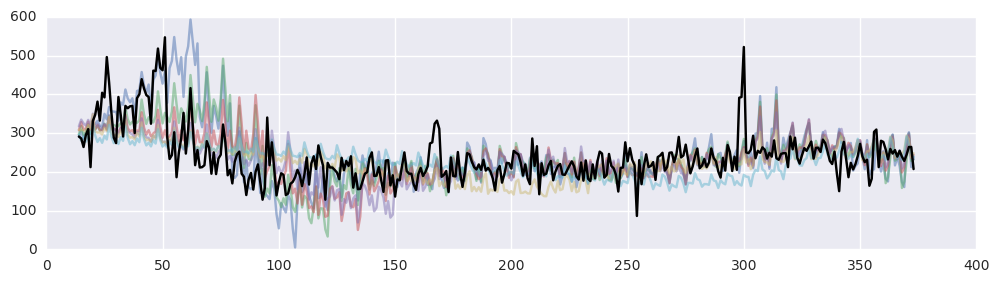

In [760]:
df_shop = df_train[df_train.shop_id == 1].reset_index(drop=1)

plt.figure(figsize=(12, 3))

#plt.plot(df_shop.days_from_beginning, df_shop.store_overall_trend)
# plt.plot(df_shop.days_from_beginning, df_shop.trend_2)
# plt.plot(df_shop.days_from_beginning, df_shop.trend_3)
# plt.plot(df_shop.days_from_beginning, df_shop.trend_4)
plt.plot(df_shop.days_from_beginning, df_shop.trend_dow_3, alpha=0.5)
plt.plot(df_shop.days_from_beginning, df_shop.trend_dow_4, alpha=0.5)
plt.plot(df_shop.days_from_beginning, df_shop.trend_dow_5, alpha=0.5)
plt.plot(df_shop.days_from_beginning, df_shop.trend_dow_6, alpha=0.5)
plt.plot(df_shop.days_from_beginning, df_shop.trend_dow_12, alpha=0.5)
plt.plot(df_shop.days_from_beginning, df_shop.trend_dow_18, alpha=0.5)

plt.plot(df_shop.days_from_beginning, df_shop.pays_count, color='black')

plt.show()

## Baseline

In [200]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [193]:
from sklearn.metrics import mean_squared_error

def rmse(y, y_pred):
    y_pred = y_pred[~np.isnan(y)]
    y = y[~np.isnan(y)]

    y = y[~np.isnan(y_pred)]
    y_pred = y_pred[~np.isnan(y_pred)]

    return np.sqrt(mean_squared_error(y, y_pred))

In [680]:
y_train = df_train.pays_count.values
y_val = df_val.pays_count.values

In [818]:
features = [
    'pays_two_weeks_ago', 
    'penultimate', 
    'penultimate_biweekly_trend', 
    'penultimate_weekly_trend', 'store_dow_trend',
    'store_overall_trend', 'store_weekend_trend',
    'trend_2', 'trend_3', 'trend_4', 'trend_5', 'trend_6', 'trend_12', 'trend_18',
    'trend_dow_3', 'trend_dow_4', 'trend_dow_5', 'trend_dow_6', 
    'trend_dow_12', 'trend_dow_18', 
    'trend_weekend_3', 'trend_weekend_4', 'trend_weekend_5', 'trend_weekend_6', 
    'trend_weekend_12', 'trend_weekend_18'
]

for c in features:
    print('%30s' % c, end=': ')
    print('%.4f' % rmse(y_train, df_train[c].values), end=', ')
    print('%.4f' % evaluation_metric(y_train, df_train[c]))
print()

for c in features:
    print('%30s' % c, end=': ')
    print('%.4f' % rmse(y_val, df_val[c].values), end=', ')
    print('%.4f' % evaluation_metric(y_val, df_val[c]))

            pays_two_weeks_ago: 65.3115, 0.1636
                   penultimate: 62.6715, 0.1547
    penultimate_biweekly_trend: 62.5666, 0.1509
      penultimate_weekly_trend: 62.5052, 0.1510
               store_dow_trend: 51.4179, 0.1396
           store_overall_trend: 60.3194, 0.1588
           store_weekend_trend: 52.8553, 0.1430
                       trend_2: 67.6710, 0.1712
                       trend_3: 65.3711, 0.1686
                       trend_4: 64.2930, 0.1662
                       trend_5: 64.0701, 0.1650
                       trend_6: 63.6432, 0.1631
                      trend_12: 63.3498, 0.1648
                      trend_18: 60.6181, 0.1628
                   trend_dow_3: 62.2862, 0.1602
                   trend_dow_4: 60.4358, 0.1550
                   trend_dow_5: 59.0335, 0.1521
                   trend_dow_6: 58.1758, 0.1497
                  trend_dow_12: 56.4282, 0.1478
                  trend_dow_18: 53.2653, 0.1455
               trend_weekend_3: 60.3747,


features
pays_two_weeks_ago


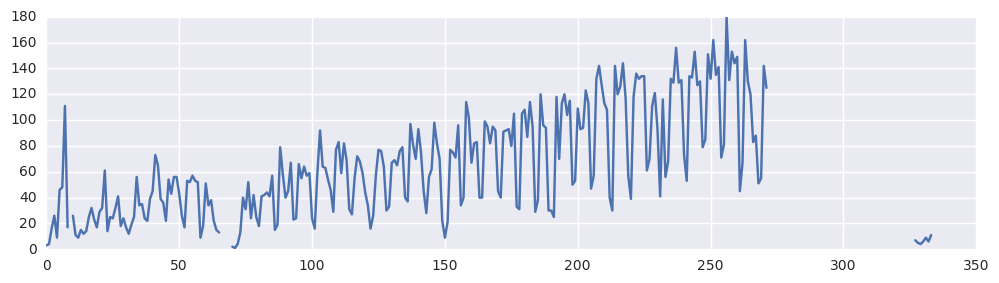

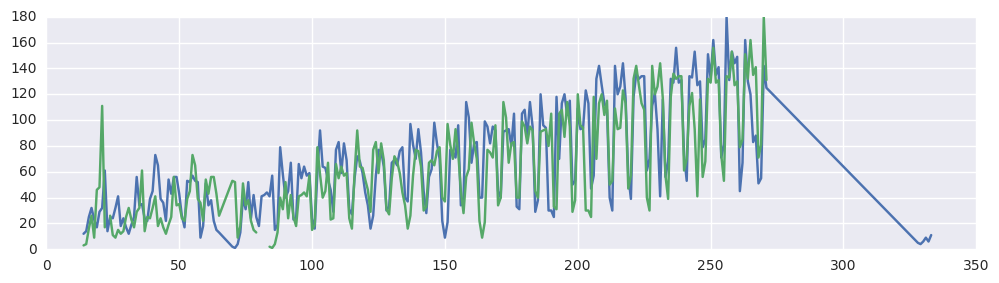

penultimate


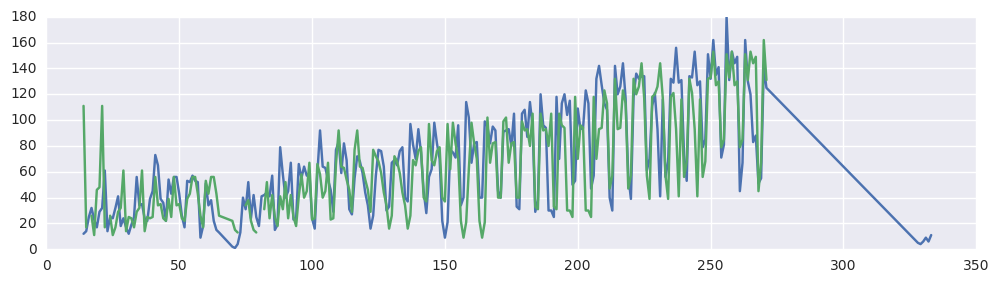

store_dow_trend


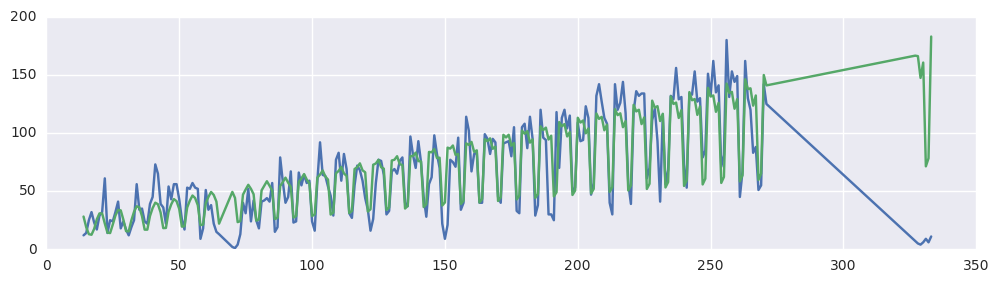

store_overall_trend


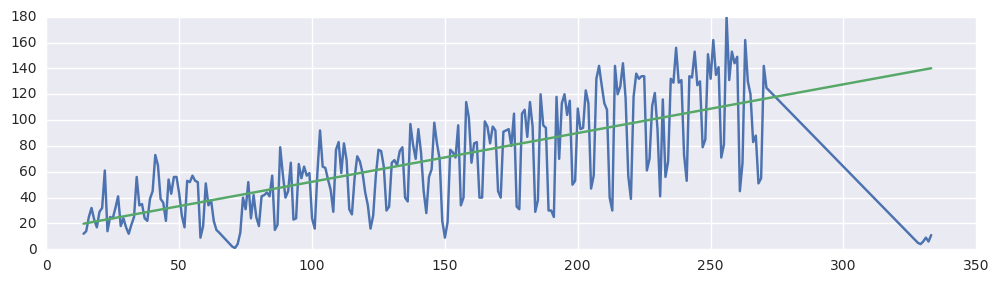

store_weekend_trend


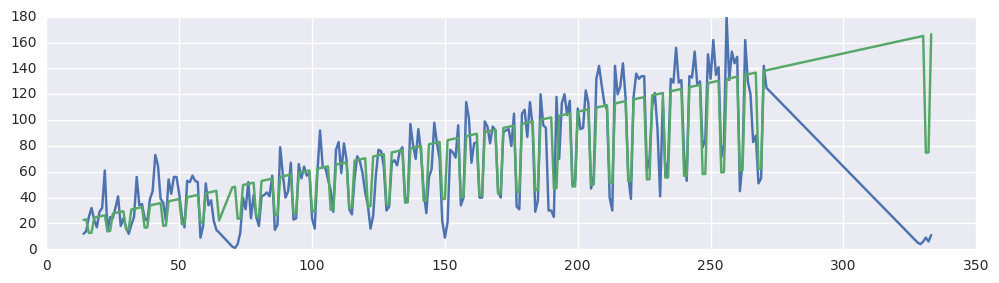

trend_dow_3


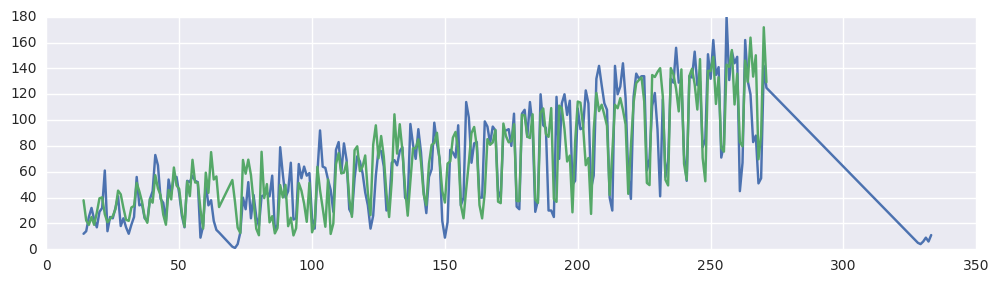

trend_weekend_3


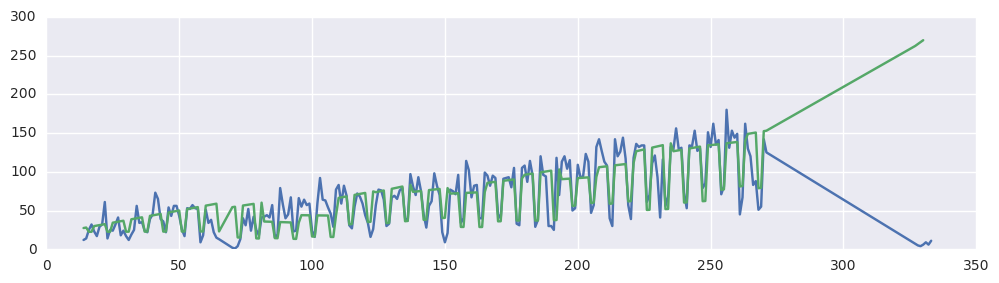

In [819]:
features = [
    'pays_two_weeks_ago', 
    'penultimate', 
    'store_dow_trend',
    'store_overall_trend', 'store_weekend_trend',
    'trend_dow_3',
    'trend_weekend_3',
]

shop_id = 810
df_shop = df_pays[df_pays.shop_id == shop_id]
plt.figure(figsize=(12, 3))
plt.plot(df_shop.days_from_beginning, df_shop.pays_count)


print()
print('features')
df_shop = pd.concat([df_train[df_train.shop_id == shop_id], 
                     df_val[df_val.shop_id == shop_id]])

for c in features:
    print(c)
    plt.figure(figsize=(12, 3))
    plt.plot(df_shop.days_from_beginning, df_shop.pays_count)
    plt.plot(df_shop.days_from_beginning, df_shop[c])
    plt.show()


## Linear Model

In [392]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

In [773]:
features = [
    'pays_two_weeks_ago', 
    'penultimate', #'penultimate_null', 
    'penultimate_biweekly_trend', 
    'penultimate_weekly_trend', 'store_dow_trend',
    'store_overall_trend', 'store_weekend_trend',
    'trend_2', 'trend_3', 'trend_4', 'trend_5', 'trend_6', 'trend_12', 'trend_18',
    'trend_dow_3', 'trend_dow_4', 'trend_dow_5', 'trend_dow_6', 
    'trend_dow_12', 'trend_dow_18', 
    'trend_weekend_3', 'trend_weekend_4', 'trend_weekend_5', 'trend_weekend_6', 
    'trend_weekend_12', 'trend_weekend_18'

]

In [774]:
X_train = df_train[features].fillna(0).values
X_val = df_val[features].fillna(0).values

In [775]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [686]:
for a in [0.1, 1]:
    lr = Lasso(alpha=a)
    lr.fit(X_train_scaled, y_train)

    y_pred = lr.predict(X_val_scaled)
    print(a, rmse(y_val, y_pred))

0.1 44.7300839369
1 46.4977746994


In [776]:
for a in [0.001, 0.01]:
    lr = Lasso(alpha=a)
    lr.fit(X_train_scaled, y_train)

    y_pred = lr.predict(X_val_scaled)
    print(a, rmse(y_val, y_pred))

/home/agrigorev/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


0.001 44.6160812538
0.01 44.6521948184


### Median trend features

In [777]:
trend_groups = [
    ('trend', ['trend_2', 'trend_3', 'trend_4', 'trend_5', 'trend_6', 'trend_12', 'trend_18']),
    ('trend_dow', ['trend_dow_3', 'trend_dow_4', 'trend_dow_5', 'trend_dow_6', 
                   'trend_dow_12', 'trend_dow_18']),
    ('trend_weekend', ['trend_weekend_3', 'trend_weekend_4', 'trend_weekend_5',
                       'trend_weekend_6', 'trend_weekend_12', 'trend_weekend_18']),
]

In [778]:
for n, g in trend_groups:
    df_train[n + '_median'] = df_train[g].median(axis=1)
    df_val[n + '_median'] = df_val[g].median(axis=1)
    df_train[n + '_std'] = df_train[g].std(axis=1)
    df_val[n + '_std'] = df_val[g].std(axis=1)

## Model

In [733]:
import xgboost as xgb

In [822]:
to_exclude = {
    'shop_id', 
    'day', 'days_from_beginning', 'pays_count', 'week_id', 'biweek_id',
}
features = sorted(set(df_train.columns) - to_exclude)
features

['biweekly_coef',
 'biweekly_trend',
 'dow',
 'is_weekend',
 'ooo_mean_1',
 'ooo_mean_2',
 'ooo_mean_3',
 'ooo_mean_4',
 'out_of_operation',
 'pays_two_weeks_ago',
 'penultimate',
 'penultimate_biweekly_trend',
 'penultimate_null',
 'penultimate_weekly_trend',
 'second_in_biweek',
 'store_dow_trend',
 'store_overall_trend',
 'store_weekend_trend',
 'trend_12',
 'trend_18',
 'trend_2',
 'trend_3',
 'trend_4',
 'trend_5',
 'trend_6',
 'trend_coef_12',
 'trend_coef_18',
 'trend_coef_2',
 'trend_coef_3',
 'trend_coef_4',
 'trend_coef_5',
 'trend_coef_6',
 'trend_dow_12',
 'trend_dow_18',
 'trend_dow_3',
 'trend_dow_4',
 'trend_dow_5',
 'trend_dow_6',
 'trend_dow_coef_12',
 'trend_dow_coef_18',
 'trend_dow_coef_3',
 'trend_dow_coef_4',
 'trend_dow_coef_5',
 'trend_dow_coef_6',
 'trend_dow_median',
 'trend_dow_std',
 'trend_median',
 'trend_std',
 'trend_weekend_12',
 'trend_weekend_18',
 'trend_weekend_3',
 'trend_weekend_4',
 'trend_weekend_5',
 'trend_weekend_6',
 'trend_weekend_coef_12',

In [823]:
X_train = df_train[features].values
X_val = df_val[features].values

In [341]:
def eval_metric(preds, dtrain):
    y_true = dtrain.get_label()
    return 'metric', evaluation_metric(y_true, preds)

In [831]:
def obj_mse(preds, dtrain):
    y = dtrain.get_label()
    grad = preds - y
    hess = np.ones_like(y)
    return grad, hess

def obj_comp(preds, dtrain):
    y = dtrain.get_label()
    obj = (y - preds) / (y + preds)
    grad = - 2 * y / (y + preds)
    grad[obj < 0] = -grad[obj < 0]
    hess = 4 * y / (y + preds) ** 2
    hess[obj < 0] = -hess[obj < 0]
    return grad, hess


def ln_cosh_obj(preds, dtrain):
    y = dtrain.get_label()
    grad = np.tanh(preds - y)
    hess = 1 - grad * grad
    return grad, hess

fair_constant = 100
def fair_obj(preds, dtrain):
    labels = dtrain.get_label()
    x = (preds - labels)
    den = abs(x) + fair_constant
    grad = fair_constant * x / (den)
    hess = fair_constant * fair_constant / (den * den)
    return grad, hess

In [835]:
xgb_pars = {
    'eta': 0.3,
    'gamma': 0,
    'max_depth': 8,
    'min_child_weight': 1,
    'max_delta_step': 0,
    'subsample': 1,
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'lambda': 1,
    'alpha': 0,
    'tree_method': 'approx',
    'objective': 'reg:linear',
    #'objective': 'count:poisson',
    'eval_metric': 'rmse',
    'nthread': 8,
    'seed': 42,
    'silent': 1
}

n_estimators = 101

In [836]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features, missing=np.nan)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features, missing=np.nan)
watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(xgb_pars, dtrain, num_boost_round=n_estimators, verbose_eval=10, 
                  evals=watchlist, feval=eval_metric)

[0]	train-rmse:129.083	val-rmse:152.77	train-metric:0.506041	val-metric:0.504093
[10]	train-rmse:45.636	val-rmse:57.8838	train-metric:0.117848	val-metric:0.106022
[20]	train-rmse:43.4211	val-rmse:56.8149	train-metric:0.116936	val-metric:0.106594
[30]	train-rmse:41.3261	val-rmse:57.2904	train-metric:0.115693	val-metric:0.106273
[40]	train-rmse:40.1797	val-rmse:57.603	train-metric:0.113938	val-metric:0.106137
[50]	train-rmse:38.8083	val-rmse:58.4183	train-metric:0.112284	val-metric:0.105858
[60]	train-rmse:37.739	val-rmse:58.9748	train-metric:0.111183	val-metric:0.106097
[70]	train-rmse:36.9856	val-rmse:59.0351	train-metric:0.110018	val-metric:0.106001
[80]	train-rmse:35.7337	val-rmse:58.8989	train-metric:0.109036	val-metric:0.105977
[90]	train-rmse:34.8187	val-rmse:59.1356	train-metric:0.108185	val-metric:0.106168
[100]	train-rmse:34.0723	val-rmse:59.3194	train-metric:0.107429	val-metric:0.106291


In [649]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features, missing=np.nan)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features, missing=np.nan)
watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(xgb_pars, dtrain, num_boost_round=n_estimators, verbose_eval=10, 
                  evals=watchlist, feval=eval_metric)#, obj=obj_comp)

[0]	train-rmse:161.426	val-rmse:190.141	train-metric:0.771009	val-metric:0.784309
[10]	train-rmse:83.6099	val-rmse:93.8214	train-metric:0.202507	val-metric:0.172867
[20]	train-rmse:64.8092	val-rmse:69.1391	train-metric:0.13933	val-metric:0.109331
[30]	train-rmse:60.6886	val-rmse:61.3233	train-metric:0.131448	val-metric:0.106436


In [785]:
y_pred = model.predict(dval)
evaluation_metric(y_val, y_pred)

0.10491181065494183

In [786]:
rmse(y_val, y_pred)

57.164053316969948

In [787]:
df_val['pred'] = np.round(y_pred)

In [788]:
scores = model.get_score(importance_type='gain')
sorted(scores.items(), key=lambda x: -x[1])

[('trend_weekend_5', 119960375.24000001),
 ('store_dow_trend', 115673397.88811475),
 ('trend_weekend_median', 32330197.42857143),
 ('biweekly_coef', 32054615.16129032),
 ('trend_dow_median', 19853991.59375),
 ('trend_weekend_std', 14439988.142105263),
 ('penultimate', 13252305.239130436),
 ('trend_std', 11079637.284444444),
 ('trend_dow_4', 10779563.5),
 ('store_overall_trend', 10317283.333333334),
 ('trend_dow_coef_12', 10194518.666666666),
 ('trend_weekend_3', 9194600.219402986),
 ('trend_coef_12', 8362558.711111112),
 ('trend_weekend_6', 6958673.314285715),
 ('trend_weekend_coef_12', 6289616.083333333),
 ('trend_weekend_coef_18', 6144927.266666667),
 ('pays_two_weeks_ago', 5448856.04),
 ('biweekly_trend', 5034460.428571428),
 ('dow', 4962304.800735294),
 ('trend_dow_std', 4932982.833333333),
 ('trend_coef_2', 4480070.906060606),
 ('trend_2', 4315404.423958333),
 ('trend_3', 4114012.9),
 ('penultimate_biweekly_trend', 3720639.1666666665),
 ('trend_dow_18', 3397484.8133333335),
 ('ooo

In [789]:
set(features) - scores.keys()

{'is_weekend', 'out_of_operation', 'penultimate_null'}

In [790]:
nom = (df_val.pays_count - df_val.pred).abs()
denom = (df_val.pays_count + df_val.pred)
df_val['score'] = nom / denom

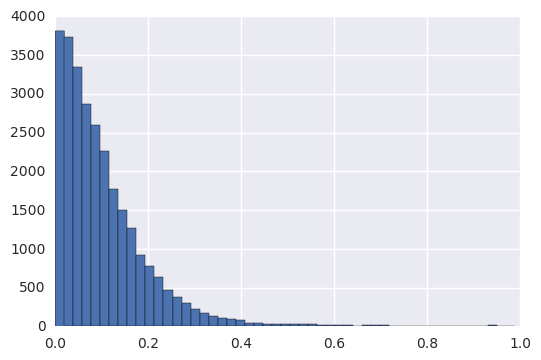

In [791]:
df_val.score.hist(bins=51)

In [792]:
val_mean_score = df_val.groupby('shop_id').score.mean()
val_mean_score.sort_values(ascending=False)

shop_id
810     0.873873
1556    0.770528
1918    0.738300
1464    0.591090
23      0.562445
632     0.526884
474     0.473548
742     0.470149
1526    0.465290
1747    0.420642
1548    0.410829
1384    0.397946
727     0.396424
459     0.378182
1214    0.357084
1968    0.355248
1100    0.344260
125     0.332335
619     0.323032
524     0.321949
1447    0.319534
283     0.318132
1856    0.315534
749     0.303310
521     0.300273
1107    0.297649
352     0.297108
1124    0.295466
399     0.292022
1218    0.290536
          ...   
1146    0.036271
1355    0.036218
973     0.036098
1874    0.036057
1469    0.035528
909     0.034437
1413    0.034403
824     0.034300
1157    0.034291
1014    0.034259
1624    0.034008
1365    0.033538
1885    0.033493
1441    0.033470
240     0.033464
468     0.033378
565     0.033024
20      0.032294
88      0.031850
171     0.031627
318     0.031570
362     0.031213
323     0.030467
854     0.028866
516     0.028376
1148    0.028061
1392    0.026722
1489  

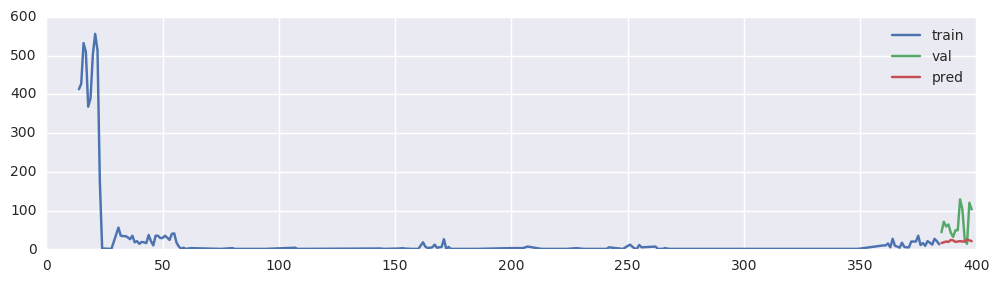

In [793]:
shop_id = 1526
df_shop_train = df_train[df_train.shop_id == shop_id]
df_shop_val = df_val[df_val.shop_id == shop_id]

plt.figure(figsize=(12, 3))
plt.plot(df_shop_train.days_from_beginning, df_shop_train.pays_count, label='train')
plt.plot(df_shop_val.days_from_beginning, df_shop_val.pays_count, label='val')
plt.plot(df_shop_val.days_from_beginning, df_shop_val.pred, label='pred')
plt.legend()
plt.show()

In [794]:
evaluation_metric(y_val, df_val.penultimate)

0.09024919457575448

In [353]:
actual = []
pred = []

for i in tqdm(shops):
    df_train_shop = df_train[df_train.shop_id == i]
    y_train_shop = df_train_shop.pays_count.values
    X_train_shop = df_train_shop[features].values

    df_val_shop = df_val[df_val.shop_id == i]
    y_val_shop = df_val_shop.pays_count.values
    X_val_shop = df_val_shop[features].values


100%|██████████| 2000/2000 [00:15<00:00, 125.09it/s]
